In [43]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from gurobipy import *

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Read the provided data via `pandas/geopandas`.  
Remove duplicates (by column 'plz') from `zuordnung_plz_ort.csv`. Make sure that all data frames contain the same number of rows.  
Append the state names to both the 'shape' and 'centroid' data frames.  
Reference: [read_file](https://geopandas.org/reference/geopandas.read_file.html), [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [drop_duplicates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html), [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html)

In [49]:
###############################################
# Set path to the different files here
###############################################
shp_file_centeroid = "/Users/lukasbahr/POM/political_districting/data/plz-5stellig-centroid.shp"
shp_file  = "/Users/lukasbahr/POM/political_districting/data/plz-5stellig.shp"
csv_zuordnung  = "/Users/lukasbahr/POM/political_districting/data/zuordnung_plz_ort.csv"
###############################################


def getPolititcalDistrictData(shp_file_centeroid, shp_file, csv_zuordnung,
        state):
    """
    Return border and center geopanda dataframe containing all plz of
    a specific state.

    """
    # Create drop list of plz not in a state
    df_PLZ_BL = getDF_CSVZuordnung(csv_zuordnung, state)
    drop = list(df_PLZ_BL['plz'])

    # Drop plz in geopanda dataframes
    df_Border = dropPLZ(shp_file, drop)
    df_Center = dropPLZ(shp_file_centeroid, drop)

    # Check if rows of dataframes are matching
    if len(df_Border)  == len(df_Center) == len(df_PLZ_BL):
        # Merge state column to geopanda dataframe
        df_Border = df_Border.merge(df_PLZ_BL[['bundesland', 'plz']], left_on =
                'plz', right_on = 'plz')
        df_Center = df_Center.merge(df_PLZ_BL[['bundesland', 'plz']], left_on =
                'plz', right_on = 'plz')

        return df_Border, df_Center

    else:
        print("Rows of dataframes are not matching.")


def dropPLZ(path, drop_plz):
    """
    Return a geopanda dataframe for only specified plz.

    """
    df = gpd.read_file(path)
    # Drop all not necessary plz
    df.drop(df[~df['plz'].str.contains('|'.join(str(x) for x in
        drop_plz))].index, axis=0, inplace=True)
    df.drop(['note'], axis=1, inplace = True)
    df['plz'] = df['plz'].astype(int)

    return df


def getDF_CSVZuordnung(path, state):
    """
    Return a panda dataframe with plz of a specified state.
    For state = "Germany" return all plz of Germany.

    """
    df = pd.read_csv(path)
    df.drop_duplicates(subset ="plz", keep = 'first', inplace = True)

    if state != "Germany":
        df.drop(df[df['bundesland'] != state].index, axis=0, inplace=True)

    return df

Create a contiguity graph $G$ as described on tutOR.

In [45]:
def createGraph(df_Border):
    """
    Return a graph from geopanda dataframe fullfilling the contiguity
    requirement.

    """
    # Find all borders for every plz in border dataframe
    df_Border = findSharedBorders(df_Border)
    # Create graph
    G = nx.Graph()
    for index, row in df_Border.iterrows():
        # Add population to node
        G.add_node(row['plz'], population=row['einwohner'])
        # Connect all neigbouring nodes
        for neighbour in row['neighbours']:
            G.add_edge(row['plz'], neighbour)

    return G


def findSharedBorders(df_Border):
    """
    Return geopanda dataframe with column of neighbouring plz.

    """
    df_Border["neighbours"] = None
    # Iterate over dataframe
    for index, row in df_Border.iterrows():
        # Make list of connecting borders
        neighbors = df_Border[~df_Border.geometry.disjoint(row.geometry)].plz.tolist()
        neighbors = [ plz for plz in neighbors if row.plz != plz ]
        # Add neighbouring plz to each plz
        df_Border.at[index, "neighbours"] = neighbors

    return df_Border

Plot the map of Saarland. The following details need to be present in the picture:
* the borders of each postcode
* the centroids of each postcode
* the lines connecting the centroids of neighboring postcodes

Reference: [Mapping Tools](https://geopandas.org/mapping.html), [pyplot](https://matplotlib.org/tutorials/introductory/pyplot.html), [touches](https://geopandas.org/reference.html#geopandas.GeoSeries.touches)

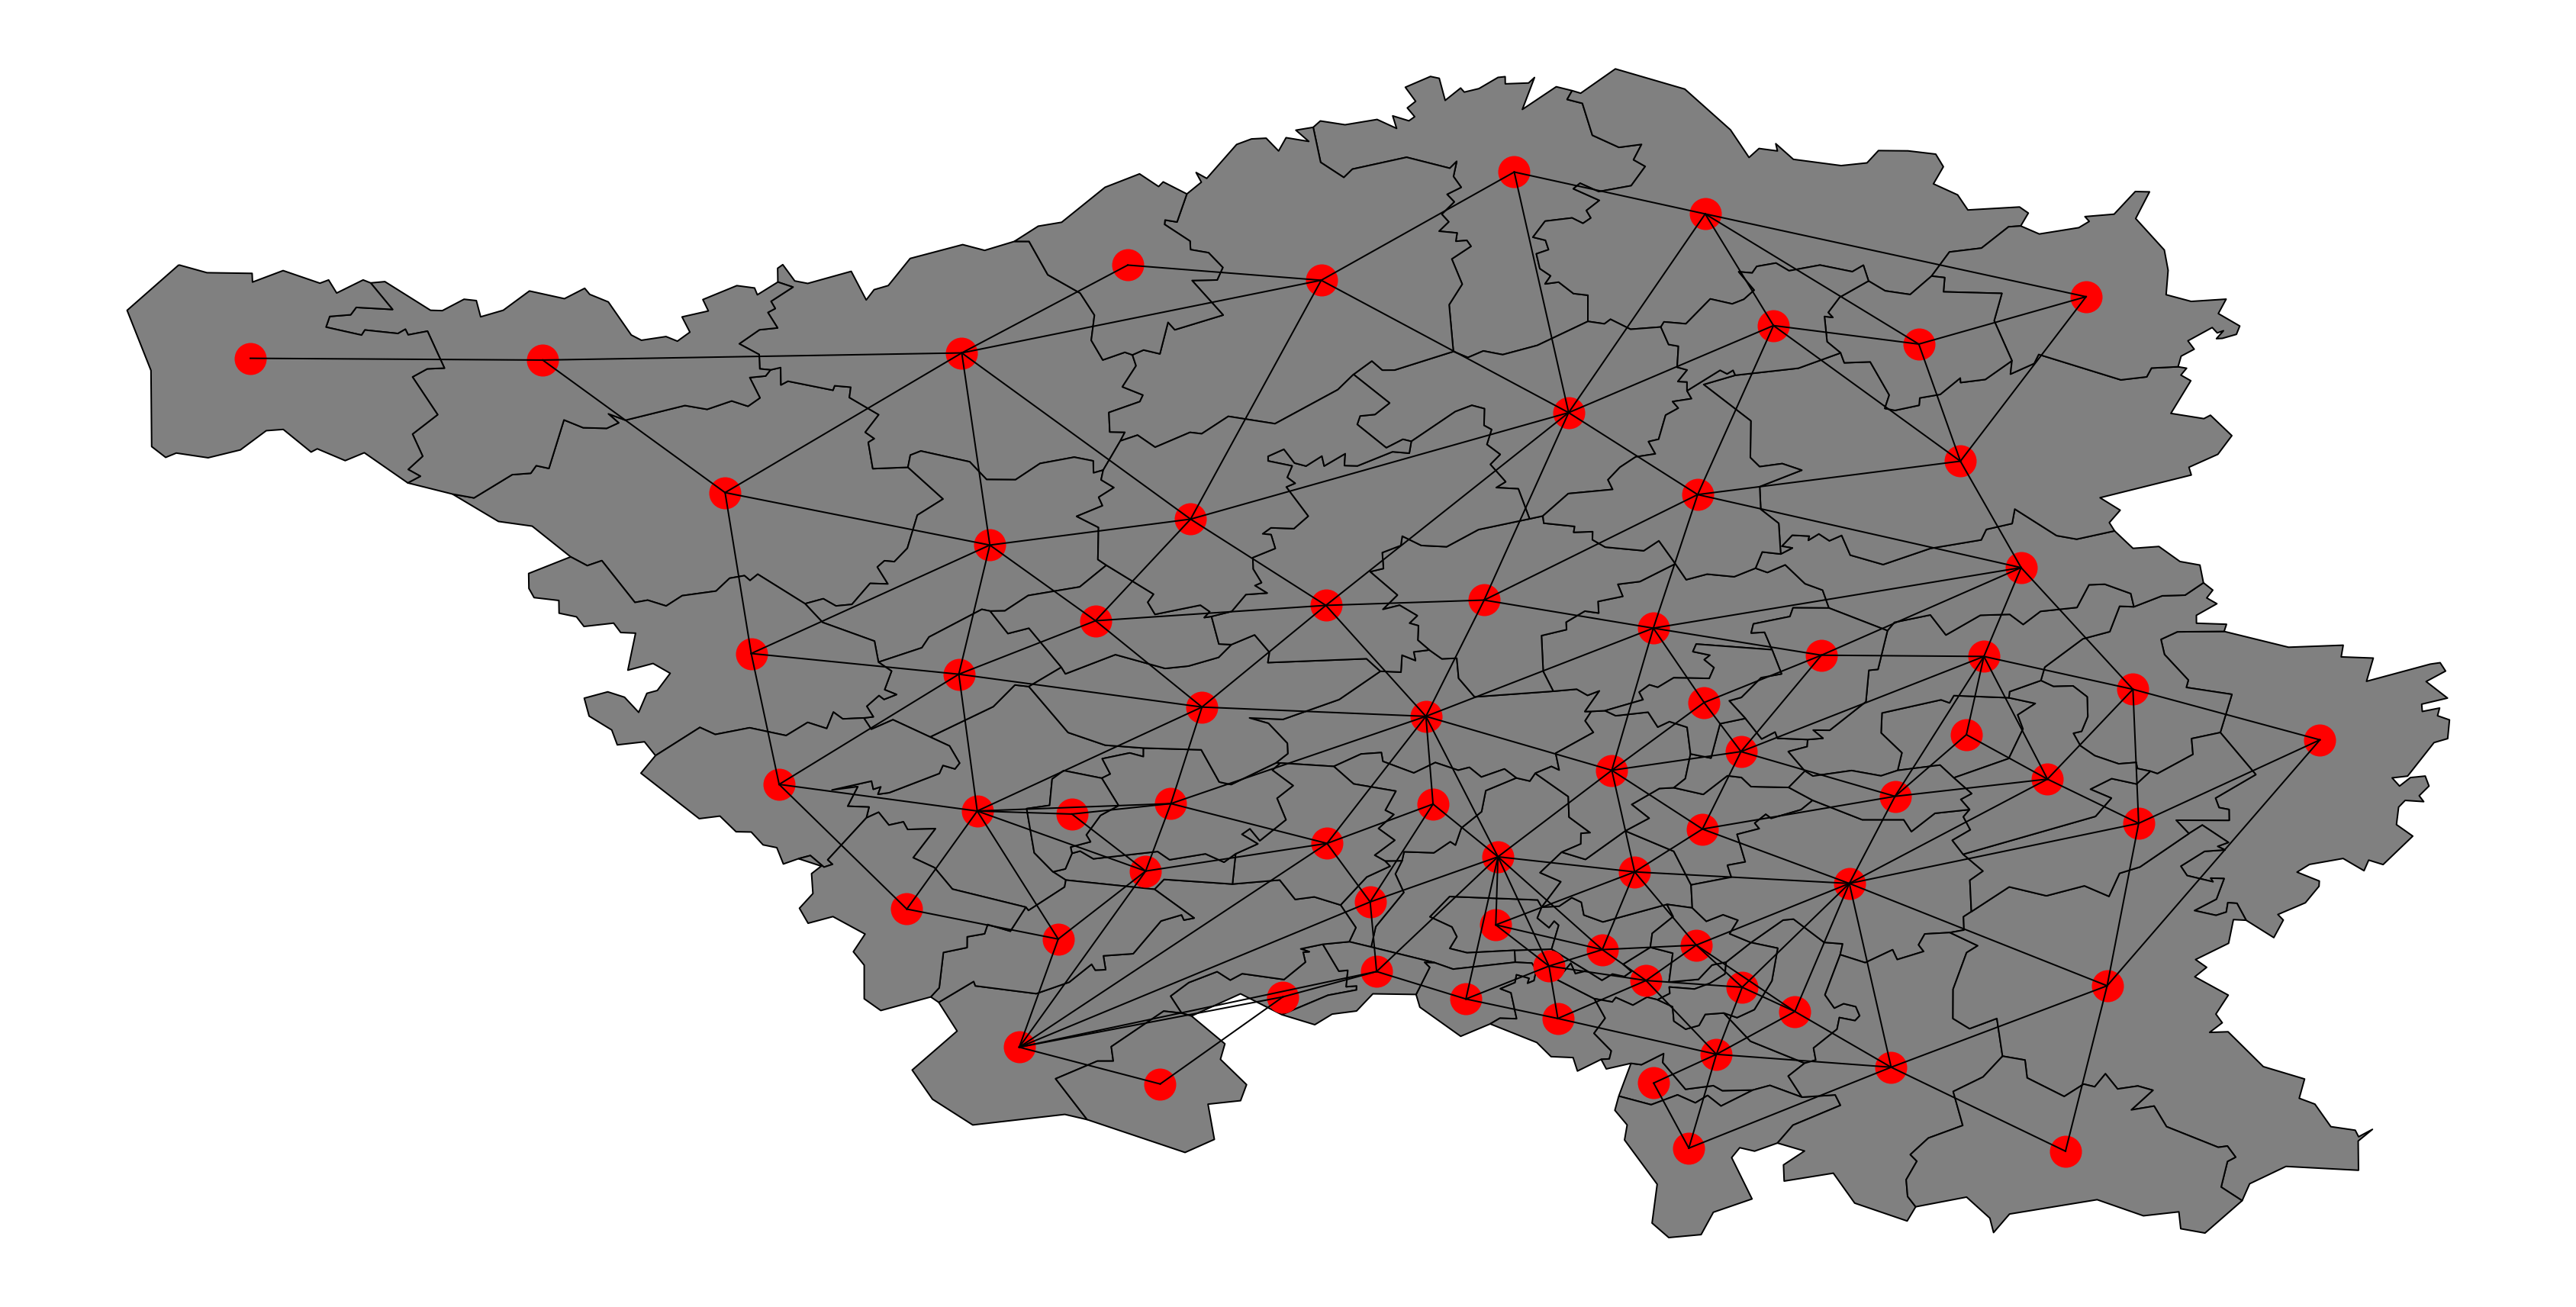

In [48]:
def plotMap(df_Border, df_Center):
    """
    Plot the map of a state containing,
    * the borders of each postcode
    * the centroids of each postcode
    * the lines connecting the centroids of neighboring postcodes

    """
    df_Border = findSharedBorders(df_Border)
    G = createGraph(df_Border)

    # Create subplots
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(30, 70))
    ax = fig.add_subplot()
    ax.set_aspect('equal')


    # Plot the connecting lines of all edges
    for x, y in G.edges:
        for index, row in df_Center.iterrows():
            if row['plz'] == x:
                point_1 = [row.geometry.centroid.x, row.geometry.centroid.y]
            elif row['plz'] == y:
                point_2 = [row.geometry.centroid.x, row.geometry.centroid.y]
            else:
                continue

        plt.plot([point_1[0], point_2[0]], [point_1[1], point_2[1]],
            color='k', linestyle = '-', linewidth =1.0)

    # Plot the border
    df_Border.plot(label='Border', ax=ax, color='grey', edgecolor='black')
    # Plot the centroids
    df_Center.plot(label='Center', ax=ax, color='red', marker = 'o',
            markersize=400)
    

    plt.axis('off')
    plt.show()
    
    
###############################################
# Plot map for Saarland
###############################################
df_Border, df_Center = getPolititcalDistrictData(shp_file_centeroid, shp_file, csv_zuordnung, "Saarland")
plotMap(df_Border, df_Center)

Model the problem.
Upload the model to tutOR.

Split Saarland into 3 districts with the required district population being equal to 340000.

In [ ]:
k = 3
req_p = 340000

In [ ]:
###############################################
# Calculate solution for Saarland
###############################################
df_Border, df_Center = getPolititcalDistrictData(shp_file_centeroid, shp_file, csv_zuordnung, "Saarland")
G = createGraph(df_Border)
model = solve(G, k, req_p)

Use the `Gurobi` solution to plot the map of Saarland with each district colored in different color.

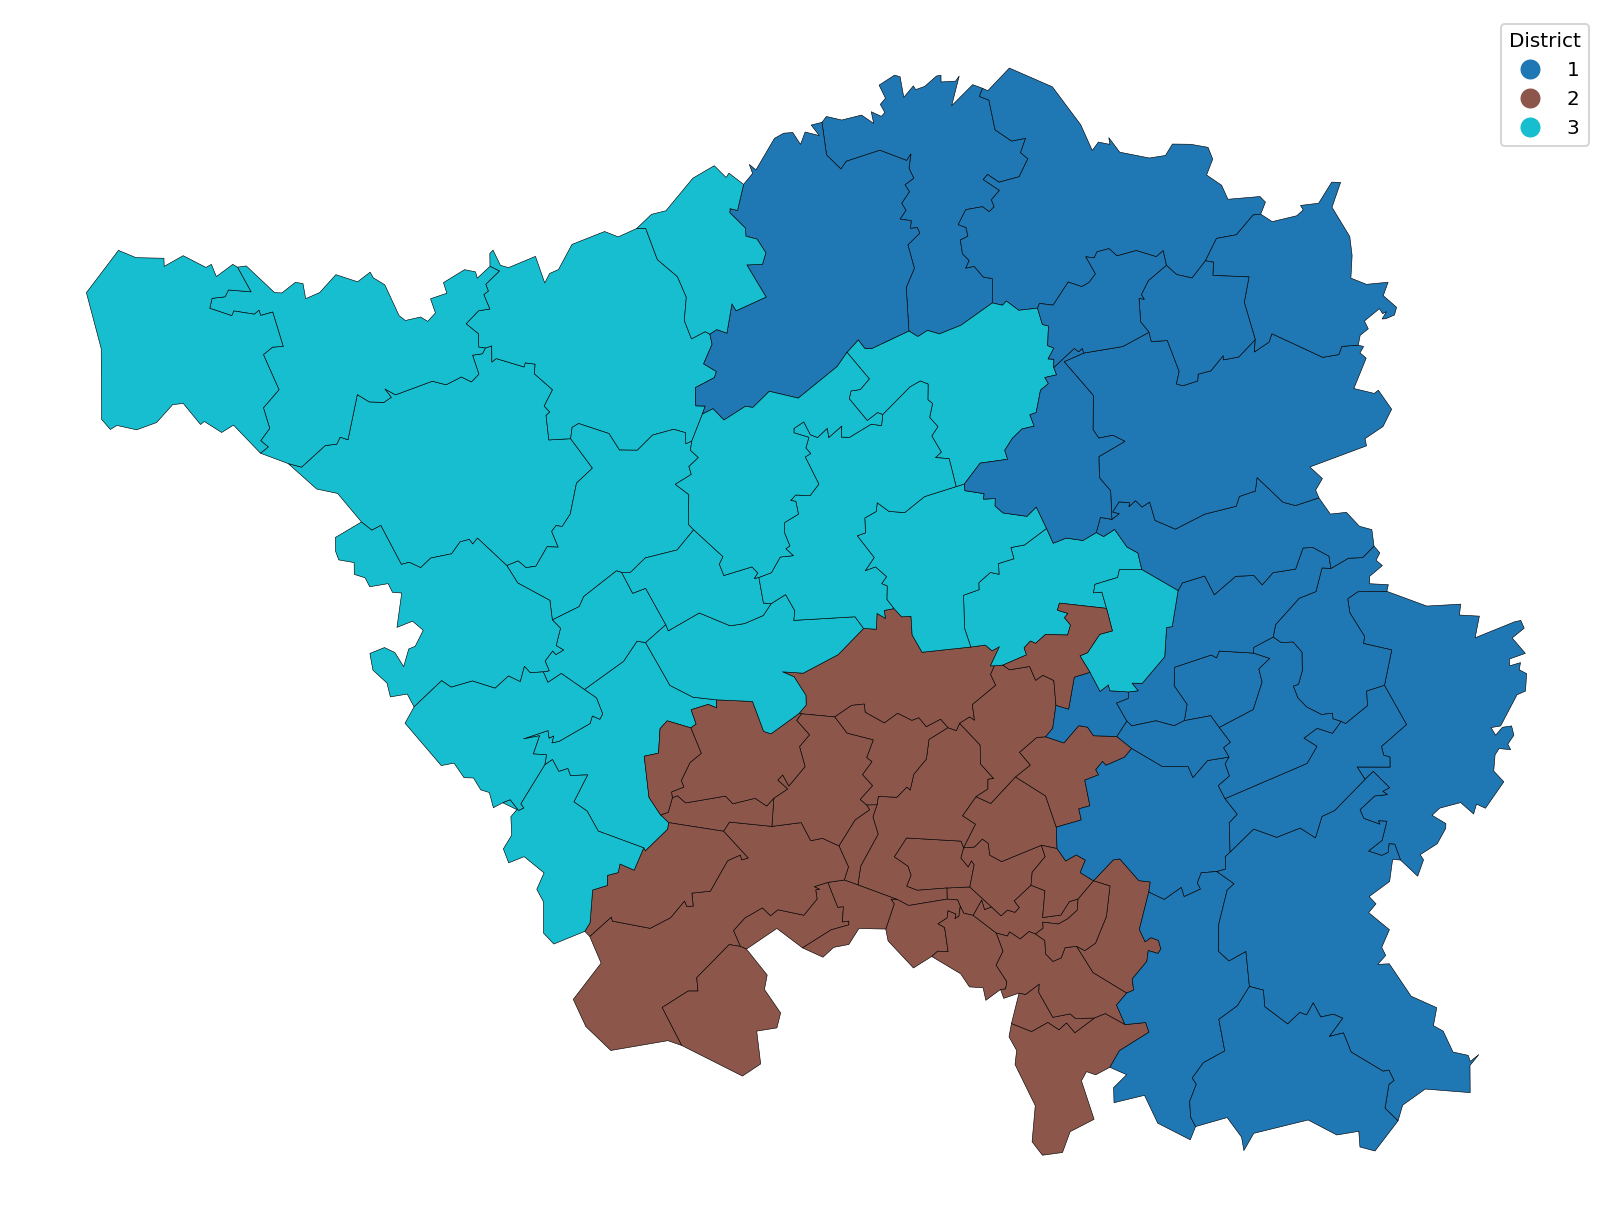

In [28]:
def plotDistricts(model, k, df_Border):
    """
    Plot the map of a state with the solution of the gurobi model.

    """
    df_Border = findSharedBorders(df_Border)
    # Find the plz for the districts
    districtedPlz = allocateDistricts(model, k)

    # Add district value to corresponding plz in df_Border
    df_Border["district"] = None
    for index, row in df_Border.iterrows():
        for district, plz in districtedPlz.items():
            if row["plz"] in plz:
                d = district
                break
        df_Border.at[index, "district"] = d

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    df_Border.plot(column = "district", legend = True, label='Border', ax=ax)

    plt.axis('off')
    plt.show()


def allocateDistricts(model, k):
    """
    Return hash map with keys of districts and plz as values based on the
    model.

    """
    districtedPlz = {d: [] for d in range(k)}
    for item in model.getVars():
        if abs(item.x) == 1:
            districtedPlz[int(item.VarName.split('_')[-1])].append(int(item.VarName.split('_')[1]))

    return districtedPlz


###############################################
# Plot map of Saarland with colored districts
###############################################
plotDistricts(model, k, df_Border)

For each district:
* check whether the population constraint was satisfied (print the district's population)
* print the names of towns and villages assigned to it

Reference: [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html)

District 1
Population: 324649
Towns and villages:
Friedrichsthal, Sankt Ingbert, Mandelbachtal, Homburg, Blieskastel, Bexbach, Gersheim, Kirkel, Neunkirchen, Ottweiler, Spiesen-Elversberg, Sankt Wendel, Nonnweiler, Nohfelden, Freisen, Namborn, Marpingen, Oberthal, Wadern

District 2
Population: 375820
Towns and villages:
Saarbrücken, Heusweiler, Kleinblittersdorf, Sulzbach/Saar, Quierschied, Riegelsberg, Völklingen, Püttlingen, Großrosseln, Bous, Merchweiler, Schwalbach, Wadgassen, Ensdorf/Saar

District 3
Population: 299977
Towns and villages:
Illingen, Eppelborn, Schiffweiler, Tholey, Merzig, Losheim am See, Mettlach, Beckingen, Perl, Weiskirchen, Saarlouis, Dillingen/Saar, Rehlingen-Siersburg, Saarwellingen, Wallerfangen, Überherrn, Nalbach, Lebach, Schmelz

